In [21]:
import numpy as np

train_data = np.load('../data/artmakeitsports/datasets/train.npy', allow_pickle=True)
val_data = np.load('../data/artmakeitsports/datasets/validation.npy', allow_pickle=True)
test_data = np.load('../data/artmakeitsports/datasets/test.npy', allow_pickle=True)
wikiart_data = np.load("../data/artmakeitsports/datasets/wikiart_data.npy", allow_pickle=True)
rand_data = np.load("hugo.npy", allow_pickle=True)

In [3]:
wikiart_data.shape

(2, 80082)

In [29]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch

class ImageRetrievalDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_path, label_path = self.data[:, idx]
        input_image = Image.open(input_path).convert("RGB")
        label_image = Image.open(label_path).convert("RGB")

        if self.transform:
            input_image = self.transform(input_image)
            label_image = self.transform(label_image)

        return input_image, label_image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageRetrievalDataset(train_data, transform=transform)
val_dataset = ImageRetrievalDataset(val_data, transform=transform)
test_dataset = ImageRetrievalDataset(test_data, transform=transform)
wikiart_dataset = ImageRetrievalDataset(wikiart_data, transform=transform)
rand_dataset = ImageRetrievalDataset(rand_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
wikiart_loader = DataLoader(wikiart_dataset, batch_size=32, shuffle=False)
rand_loader = DataLoader(rand_dataset, batch_size=32, shuffle=False)

In [6]:
from transformers import ViTModel, ViTFeatureExtractor

model = ViTModel.from_pretrained('google/vit-base-patch32-224-in21k')
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch32-224-in21k')

2024-06-22 09:30:11.939242: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rosilva/miniconda3/envs/lori/lib::/usr/local/cuda-11.1/targets/x86_64-linux/lib
2024-06-22 09:30:11.939259: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/rosilva/miniconda3/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [7]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2):
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        loss = torch.mean(torch.pow(euclidean_distance, 2))
        return loss


In [8]:
import torch
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

# Define a directory to store TensorBoard logs
log_dir = "./logs/"

# Create a SummaryWriter instance
writer = SummaryWriter(log_dir=log_dir)

criterion = ContrastiveLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

num_epochs = 100  # Set the number of epochs based on your requirements

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, batch in enumerate(train_loader):
        inputs, labels = batch
        optimizer.zero_grad()

        # Forward pass
        input_embeddings = model(inputs).last_hidden_state[:, 0, :]
        label_embeddings = model(labels).last_hidden_state[:, 0, :]

        # Compute loss
        loss = criterion(input_embeddings, label_embeddings)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        writer.add_scalar('Train Loss', loss.item(), epoch * len(train_loader) + batch_idx)

    avg_train_loss = total_loss / len(train_loader)
    writer.add_scalar('Average Train Loss', avg_train_loss, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader)}")

    # Validation step (optional)
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch_idx, batch in enumerate(val_loader):
            inputs, labels = batch
            input_embeddings = model(inputs).last_hidden_state[:, 0, :]
            label_embeddings = model(labels).last_hidden_state[:, 0, :]

            loss = criterion(input_embeddings, label_embeddings)
            val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        writer.add_scalar('Validation Loss', avg_val_loss, epoch)
        
        print(f"Validation Loss: {val_loss/len(val_loader)}")


Epoch [1/100], Loss: 39.49399948120117
Validation Loss: 36.63301086425781
Epoch [2/100], Loss: 17.748348236083984
Validation Loss: 32.51094436645508
Epoch [3/100], Loss: 5.576029300689697
Validation Loss: 27.443572998046875
Epoch [4/100], Loss: 2.3975870609283447
Validation Loss: 20.324813842773438
Epoch [5/100], Loss: 1.524006962776184
Validation Loss: 14.338081359863281
Epoch [6/100], Loss: 1.1191396713256836
Validation Loss: 10.769659996032715
Epoch [7/100], Loss: 0.8547872304916382
Validation Loss: 8.783201217651367
Epoch [8/100], Loss: 0.6728655099868774
Validation Loss: 7.467815399169922
Epoch [9/100], Loss: 0.5359684228897095
Validation Loss: 6.6496663093566895
Epoch [10/100], Loss: 0.4421469569206238
Validation Loss: 6.05775260925293
Epoch [11/100], Loss: 0.3763711452484131
Validation Loss: 5.621587753295898
Epoch [12/100], Loss: 0.32493555545806885
Validation Loss: 5.300525665283203
Epoch [13/100], Loss: 0.2825300693511963
Validation Loss: 5.050023078918457
Epoch [14/100], Los

In [9]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 19394), started 21:53:53 ago. (Use '!kill 19394' to kill it.)

In [11]:
for batch, (inputs, label_images) in val_loader:
    print(inputs.shape)

torch.Size([3, 224, 224])


In [36]:
import torch

def compute_embeddings(model, data_loader):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs, label_images = batch
            input_embeddings = model(inputs).last_hidden_state[:, 0, :].cpu()
            label_embeddings = model(label_images).last_hidden_state[:, 0, :].cpu()
            embeddings.append(input_embeddings)
            labels.append(label_embeddings)
    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    print(labels.shape)
    print(embeddings.shape)
    return embeddings, labels

# Compute embeddings for the validation set
val_embeddings, val_labels = compute_embeddings(model, val_loader)


torch.Size([2, 768])
torch.Size([2, 768])


In [37]:
train_data

array([['../data/artmakeitsports/right/2023-04-26_01-54-06_UTC.jpg',
        '../data/artmakeitsports/right/2023-05-24_16-17-02_UTC.jpg',
        '../data/artmakeitsports/right/2023-04-28_03-22-48_UTC.jpg', ...,
        '../data/artmakeitsports/top/2024-01-02_01-15-52_UTC_3.jpg',
        '../data/artmakeitsports/top/2024-01-21_04-29-49_UTC.jpg',
        '../data/artmakeitsports/top/2023-09-18_02-27-22_UTC_1.jpg'],
       ['../data/artmakeitsports/left/2023-04-26_01-54-06_UTC.jpg',
        '../data/artmakeitsports/left/2023-05-24_16-17-02_UTC.jpg',
        '../data/artmakeitsports/left/2023-04-28_03-22-48_UTC.jpg', ...,
        '../data/artmakeitsports/bottom/2024-01-02_01-15-52_UTC_3.jpg',
        '../data/artmakeitsports/bottom/2024-01-21_04-29-49_UTC.jpg',
        '../data/artmakeitsports/bottom/2023-09-18_02-27-22_UTC_1.jpg']],
      dtype='<U61')

In [12]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm
# Function to extract embeddings
def extract_embedding(image_data):
    image = image_data.unsqueeze(0)
    with torch.no_grad():
        embedding = model(image).last_hidden_state[:, 0, :].numpy()
    return embedding

# Extract embeddings for the gallery
gallery_embeddings = []
for img_path, _ in tqdm(wikiart_dataset):
    embedding = extract_embedding(img_path)
    gallery_embeddings.append(embedding)
gallery_embeddings = np.vstack(gallery_embeddings)


  0%|          | 0/2 [00:00<?, ?it/s]

/home/rosilva/miniconda3/lib/python3.10/site-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/rosilva/miniconda3/lib/python3.10/site-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


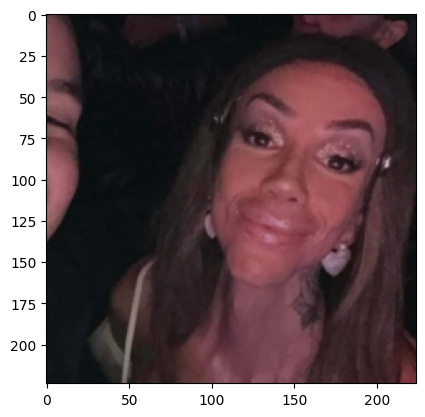

In [38]:
from matplotlib import pyplot as plt
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

inv_tensor = invTrans(rand_dataset[0][0])
plt.imshow(inv_tensor.permute(1, 2, 0))

1.08304529151011


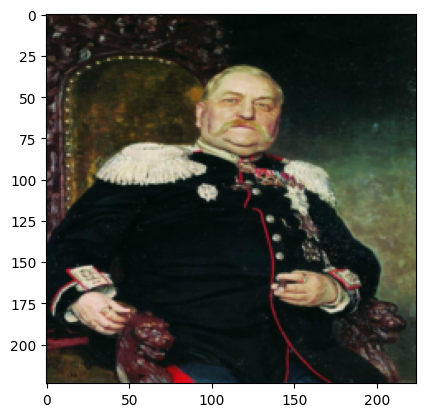

1.1089485315843675


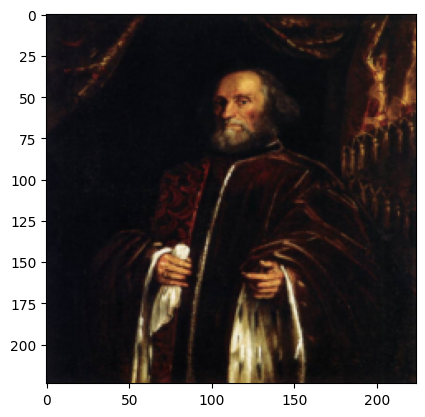

1.1160626917905803


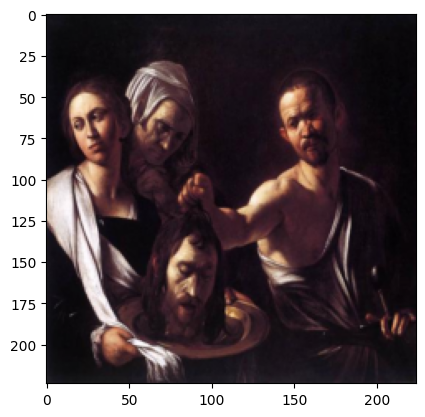

1.1332270948786918


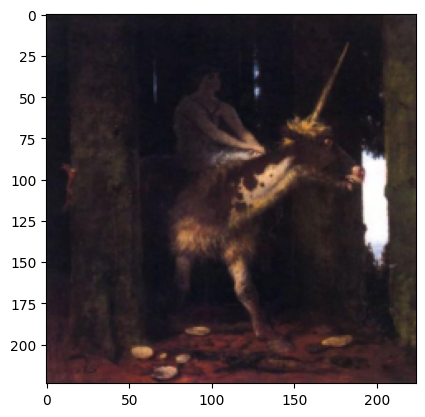

1.1375022888160566


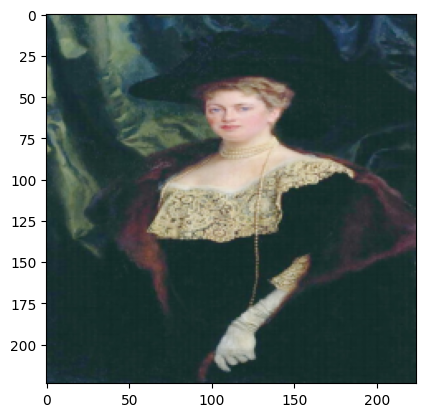

In [42]:

# Perform nearest neighbor search
def search_image(query_image_path):
    query_embedding = extract_embedding(query_image_path)
    neighbors = NearestNeighbors(n_neighbors=5, metric='euclidean')
    neighbors.fit(gallery_embeddings)
    distances, indices = neighbors.kneighbors(query_embedding)
    return indices, distances

# Example search
indices, distances = search_image(rand_dataset[0][0])
for idx, dist in zip(indices[0], distances[0]):
    inv_tensor = invTrans(wikiart_dataset[idx][1])
    print(dist)
    plt.imshow(inv_tensor.permute(1, 2, 0))
    plt.show()

In [43]:
torch.save(model.state_dict(), "../models/fine_tuned.pth")